<a href="https://colab.research.google.com/github/khodid/2020Evening/blob/master/proj4_VAE_scenery.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 처음에 시도했던 배경사진 VAE 재도전

그냥 [proj3](https://github.com/khodid/2020Evening/blob/master/proj3_MNIST_VAE.ipynb)에서 성공시킨 모델 그대로 사용할 거임

## 이미지 Import
1. Colab과 Google Drive 연결
2. dataloader 설정
3. 컴퓨팅 디바이스 설정

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


(-0.5, 47.5, 47.5, -0.5)

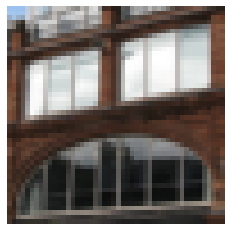

In [2]:
import torchvision
from torchvision import transforms

root = '/content/gdrive/My Drive/Kaggle/scene-classification/train-scene classification/train'

trans= transforms.Compose([
                              transforms.Resize([48, 48]),
                              transforms.ToTensor()
])

train_data = torchvision.datasets.ImageFolder(root = root, transform= trans)

import matplotlib.pyplot as plt
showimg = train_data[10][0].numpy().transpose(1,2,0)

plt.imshow(showimg) # train_data[순서][0: 이미지 / 1: 라벨]
plt.axis('off')

In [3]:
import torch.utils

# dataloader 설정
batch_size = 10
train_set = torch.utils.data.DataLoader(train_data, batch_size= batch_size, shuffle = True, drop_last = True)

In [4]:
# 디바이스 설정
import torch.cuda
device = 'cuda' if torch.cuda.is_available() else 'cpu'

torch.manual_seed(777)
if device == 'cuda' : torch.cuda.manual_seed_all(777)

In [5]:
# Checking training data shape
print(type(train_set))
for img, label in train_set:
  break
print(img.shape)

<class 'torch.utils.data.dataloader.DataLoader'>
torch.Size([10, 3, 48, 48])


## 모델 설정
1. 모델 정의(기존 proj3에서 그대로 따옴)
2. 모델 테스트
3. 모델 선언

In [6]:
import torch.nn as nn

class VAE(nn.Module):
  def __init__(self, latent_size):
    super(VAE, self).__init__()
    self.latent_size = latent_size
    self.encoder = nn.Sequential(
                                  # layer 1
                                  nn.Conv2d(3, 16, kernel_size = 5, stride = 1, padding = 2), # 3(48, 48) -> 16(48, 48)
                                  nn.BatchNorm2d(16),
                                  nn.ReLU(),
                                  
                                  #layer 2
                                  nn.Conv2d(16, 32, kernel_size = 5, stride = 2, padding=2), # 16(48, 48) -> 32(24, 24)
                                  nn.BatchNorm2d(32),
                                  nn.ReLU(),

                                  # layer 3
                                  nn. Conv2d(32, 32, kernel_size= 3, stride = 2, padding = 1), # 32(24, 24) -> 32(12, 12)
                                  nn.BatchNorm2d(32),
                                  nn.ReLU(),

                                  # output layer
                                  nn.Flatten()  # 32*12*12 = 4608
    )
    self.fc_mu = nn.Linear(4608, self.latent_size)
    self.fc_logvar = nn.Linear(4608, self.latent_size)
    self.fc_decode = nn.Linear(self.latent_size, 4608)
    self.decoder = nn.Sequential(
                                  # 
                                  # 3-T
                                  nn.ConvTranspose2d(32, 32, kernel_size = 3, stride = 2, padding=1, output_padding=1),
                                  nn.BatchNorm2d(32),
                                  nn.LeakyReLU(),

                                  # 2-T
                                  nn.ConvTranspose2d(32, 16, kernel_size=5, stride=2, padding=2, output_padding=1),
                                  nn.BatchNorm2d(16),
                                  nn.LeakyReLU(),

                                  # 1-T
                                  nn.ConvTranspose2d(16, 3, kernel_size=5, stride=1, padding=2),
                                  nn.Sigmoid()
    )
  def reparameterize(self, mu, var):
    sigma = torch.exp(0.5*var)
    epsilon = torch.randn_like(sigma)
    return mu + sigma * epsilon

  def encode(self, img):
    h = self.encoder(img)
    mu, log_var = self.fc_mu(h), self.fc_logvar(h)
    z = self.reparameterize(mu, log_var)
    return z, mu, log_var

  def decode(self, z):
    z = self.fc_decode(z)
    new_img = self.decoder(z.view(z.size(0), 32, 12, 12))
    return new_img


====== ENCODER ======
torch.Size([20, 2])
====== DECODER ======
torch.Size([20, 3, 48, 48])


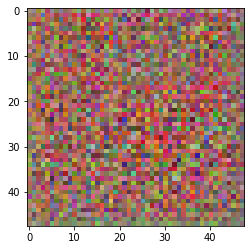

In [8]:
# model test
with torch.no_grad():
  input = torch.randn(20, 3, 48, 48).to(device)
  model = VAE(latent_size = 2).to(device)
  test_z, _, _ = model.encode(input)
  test_out = model.decode(test_z)

  print('====== ENCODER ======')
  print(test_z.shape)
  print('====== DECODER ======')
  print(test_out.shape)

  import matplotlib.pyplot as plt
  if device == 'cuda': test_out = test_out.cpu()
  show = test_out[0].view(3, 48, 48).numpy().transpose(1,2,0)
  plt.imshow(show, cmap='gray')

In [9]:
model = VAE(latent_size= 35).to(device)
model.train()

VAE(
  (encoder): Sequential(
    (0): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(16, 32, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (7): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()
    (9): Flatten()
  )
  (fc_mu): Linear(in_features=4608, out_features=35, bias=True)
  (fc_logvar): Linear(in_features=4608, out_features=35, bias=True)
  (fc_decode): Linear(in_features=35, out_features=4608, bias=True)
  (decoder): Sequential(
    (0): ConvTranspose2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running

## 학습
여기 역시 proj3에서 그대로 따옴

In [10]:
def loss_function(x, target, mu, log_var):
  x, target = x.view(-1,6912), target.view(-1, 6912) # 안 넣으면 오류남
  # r_loss = torch.sqrt(torch.mean(torch.square(target - x)) + 1e-7) # p98 참고 # 0 되는 걸 방지하기 위해
  r_loss = nn.functional.binary_cross_entropy(x, target, reduction='sum')
  kl_div = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
  return r_loss, kl_div, r_loss + kl_div

In [11]:
# 진행상황 모니터링용
tags = ['Buildings', 'Forests', 'Mountains', 'Glacier', 'Street', 'Sea']

def compare_img(img, new_img, label, epoch):
  with torch.no_grad():
    if device == 'cuda': img, new_img = img.cpu(), new_img.cpu()
    show_original = img.view(3, 48, 48).numpy().transpose(1,2,0)
    show_gen = new_img.view(3, 48, 48).numpy().transpose(1,2,0)

    plt.subplot(1, 2, 1)
    plt.title('original')
    plt.imshow(show_original, cmap='gray')
    plt.subplot(1, 2, 2)
    plt.title('generated')
    plt.imshow(show_gen, cmap = 'gray')
    
    plt.suptitle('Epoch: {} [label-{}]'.format(epoch, tags(label)), fontsize=16)
    plt.savefig('VAE_scenery_train_{}.png'.format(epoch))

    plt.clf() # 다음 그림 위해서 비워두기

In [12]:
compare_img(test_out[0],test_out[1],0, 999)

<Figure size 432x288 with 0 Axes>

In [13]:
optimizer = torch.optim.RMSprop(model.parameters(),lr = 0.001)

In [14]:
lenth = len(train_set)
print(lenth)

1702


## Training

img = img.to(device) 부분에서 

> CUDA error: device-side assert triggered

라는 오류가 발생했는데, [https://brstar96.github.io/shoveling/device_error_summary/](https://brstar96.github.io/shoveling/device_error_summary/)를 참고 해보니 이 문제는 복합적인 원인에 의해 일어나는 듯 했다.

나는 다음과 같은 해결 방법을 시도해봤다.

1. 런타임 유형을 CPU로 변경한다.(실패)
 - GPU 프로세싱 자체에서 문제가 발생했을 수 있다고 생각하여 런타임 유형을 GPU에서 CPU로 변경해보았다. 그 결과 새로 생성한 이미지의 값이 모두 NaN으로 출력되는 현상이 발생했다. 원인을 잘 모르겠다.
2. batch size를 줄여본다. (부분 실패)
 - 기존 batch size가 20이었던 것을 10으로 줄여 본다.
 - 1에서 에러가 발생한 원인을 찾음. batch size가 10일 때도 **loss가 16자리, 18자리에 육박하는 큰 수**였고, loss를 전부 합하는 방식을 채택했기 때문에 batch size가 20일 땐 훨씬 큰 수였기 때문에 오류가 발생했던 것 같음. batch size를 5로 축소했을 때도 같은 문제 발생. batch_size\*3\*64\*64 개의 loss의 총합을 구하는 것 자체가 너무 큰 것 같아서 이미지 사이즈 자체를 좀더 줄여보기로 함.
3. 이미지 크기를 줄여 본다.
  - 기존 3X64X64로 줄였던 것을 3X48X48로 다시 한 번 축소. 이미지의 형상을 알아보는 데엔 무리가 없음.
  - 3X64X64 =12288 --> 3X48X48=6912 로 계산해야 할 데이터량을 절반으로 줄임. loss 값도 4만 대로 연산 가능한 숫자로 확 줄어든 것을 관찰할 수 있었음.

In [17]:
epochs = 50
tick = [0, 5, 8, 10, 15, 20, 30, 50, 100, 120, 150, 180, 200]

model.train(True)

for epoch in range(epochs):
  for idx, (img, label) in enumerate(train_set):
    img = img.to(device)
    
    z, mu, var = model.encode(img)
    new_img = model.decode(z)
    r, k, loss = loss_function(new_img, img, mu, var)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if (idx+1) % 20 is 0 : print('Epoch [{}/{}] Step [{}/{}] loss: {} rmse: {}, kl_div: {}'.format(epoch+1, epochs, idx+1, lenth, loss.item(), r.item(), k.item()))
  if epoch in tick : compare_img(img[0], new_img[0], label[0], epoch)
compare_img(img[0], new_img[0], label[0], epoch+1)

Epoch [1/50] Step [20/1702] loss: 45152.0390625 rmse: 42260.5546875, kl_div: 2891.484375
Epoch [1/50] Step [40/1702] loss: 45869.8203125 rmse: 42979.47265625, kl_div: 2890.346923828125
Epoch [1/50] Step [60/1702] loss: 44805.80078125 rmse: 41962.8828125, kl_div: 2842.91845703125
Epoch [1/50] Step [80/1702] loss: 47789.2890625 rmse: 44580.96484375, kl_div: 3208.32470703125
Epoch [1/50] Step [100/1702] loss: 46082.953125 rmse: 43140.2421875, kl_div: 2942.708984375
Epoch [1/50] Step [120/1702] loss: 44980.4765625 rmse: 42690.5234375, kl_div: 2289.953369140625
Epoch [1/50] Step [140/1702] loss: 45173.51171875 rmse: 42681.96875, kl_div: 2491.54345703125
Epoch [1/50] Step [160/1702] loss: 45724.8359375 rmse: 42868.01171875, kl_div: 2856.82568359375
Epoch [1/50] Step [180/1702] loss: 46077.35546875 rmse: 42920.35546875, kl_div: 3156.998291015625
Epoch [1/50] Step [200/1702] loss: 45383.47265625 rmse: 42638.58203125, kl_div: 2744.890625
Epoch [1/50] Step [220/1702] loss: 50438.8515625 rmse: 47

RuntimeError: ignored

<Figure size 432x288 with 0 Axes>

In [19]:
print(loss)

RuntimeError: ignored

In [18]:
tags = ['Buildings', 'Forests', 'Mountains', 'Glacier', 'Street', 'Sea']

with torch.no_grad():
  # img[0], new_img[0], label[0]
  if device == 'cuda': img, new_img = img.cpu(), new_img.cpu()
  show_original_set = img.view(img.size(0),28, 28).numpy()
  show_gen_set = new_img.view(new_img.size(0), 28, 28).numpy()

  for i in range(8):
    show_original = show_original_set[i]
    show_gen = show_gen_set[i]

    plt.subplot(2, 8, i+1)
    plt.title('ori')
    plt.imshow(show_original, cmap='gray')
    plt.subplot(2, 8, i + 9)
    plt.title('gen')
    plt.imshow(show_gen, cmap = 'gray')
    plt.axis(False)
    
  plt.suptitle('Epoch: {}'.format(epoch+1), fontsize=16)

RuntimeError: ignored